In [1]:
import importlib
import os
import sys
import tomllib
from pathlib import Path
from pprint import pprint

import torch
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.utils import set_determinism
from torch.utils.data import DataLoader, random_split

from src.datasets.acdc_dataset import ACDCDataset
from src.transforms import get_transforms
from src.utils import find_optimal_learning_rate, setup_dirs
from src.visualization import visualize_predictions

sys.path.insert(0, "..")

In [2]:
root_dir = Path(os.getcwd()).parent
data_dir, log_dir, out_dir = setup_dirs(root_dir)
data_dir = data_dir / "ACDC" / "database"
out_dir = out_dir / "2d_UNet"
os.makedirs(out_dir, exist_ok=True)

with open(root_dir / "config.toml", "rb") as file:
    config = tomllib.load(file)

pprint(config)
batch_size = config["hyperparameters"].get("epochs", 1)
epochs = config["hyperparameters"].get("epochs", 100)
learning_rate = config["hyperparameters"].get("learning_rate", 1e-5)
percentage_data = config["hyperparameters"].get("percentage_data", 1.0)
validation_split = config["hyperparameters"].get("validation_split", 0.8)

set_determinism(seed=config["hyperparameters"]["seed"])

{'hyperparameters': {'batch_size': 1,
                     'epochs': 100,
                     'learning_rate': 1e-05,
                     'percentage_data': 1.0,
                     'seed': 42,
                     'validation_split': 0.8}}


In [3]:
importlib.reload(sys.modules["src.transforms"])
train_transforms = get_transforms(False)

train_data = ACDCDataset(
    data_dir=data_dir,
    train=True,
    transform=train_transforms,
    percentage_data=percentage_data,
)

total_training_number = len(train_data)
train_size = int(validation_split * total_training_number)
test_size = total_training_number - train_size

# TODO: cache dataset
# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=1)
# val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)

train_ds, val_ds = random_split(train_data, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=1)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm=Norm.BATCH,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
# TODO: weight decay check
optimizer = torch.optim.Adam(model.parameters())

metrics = {
    # TODO: include_background = True?
    'dice': DiceMetric(include_background=False),
    'dice_with_background': DiceMetric(include_background=True, reduction="mean"),
    'hausdorff': HausdorffDistanceMetric(include_background=False, reduction="mean"),
    'dice_per_label': DiceMetric(include_background=False, reduction="mean_batch"),
    'hausdorff_per_label': HausdorffDistanceMetric(include_background=False, reduction="mean_batch")
}

In [6]:
# Use the config learning rate as a midpoint.
optimal_learning_rate = find_optimal_learning_rate(
    model=model,
    optimizer=optimizer,
    criterion=loss_function,
    device=device,
    train_loader=train_loader,
    start_lr=learning_rate / 100,
    end_lr=learning_rate * 100,
    iterations=100,
)

if optimal_learning_rate is None:
    print("Optimal learning rate not found, using default learning rate.")
    optimal_learning_rate = learning_rate
else:
    print(f"Optimal learning rate found: {optimal_learning_rate}")

for group in optimizer.param_groups:
    group["lr"] = optimal_learning_rate

config["hyperparameters"]["optimal_learning_rate"] = optimal_learning_rate

Computing optimal learning rate, iteration 1/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and

Computing optimal learning rate, iteration 2/100
Computing optimal learning rate, iteration 3/100
Computing optimal learning rate, iteration 4/100
Computing optimal learning rate, iteration 5/100
Computing optimal learning rate, iteration 6/100
Computing optimal learning rate, iteration 7/100
Computing optimal learning rate, iteration 8/100
Computing optimal learning rate, iteration 9/100
Computing optimal learning rate, iteration 10/100
Computing optimal learning rate, iteration 11/100
Computing optimal learning rate, iteration 12/100
Computing optimal learning rate, iteration 13/100
Computing optimal learning rate, iteration 14/100
Computing optimal learning rate, iteration 15/100
Computing optimal learning rate, iteration 16/100
Computing optimal learning rate, iteration 17/100
Computing optimal learning rate, iteration 18/100
Computing optimal learning rate, iteration 19/100
Computing optimal learning rate, iteration 20/100
Computing optimal learning rate, iteration 21/100
Computin

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


Computing optimal learning rate, iteration 82/100
Computing optimal learning rate, iteration 83/100
Computing optimal learning rate, iteration 84/100
Computing optimal learning rate, iteration 85/100
Computing optimal learning rate, iteration 86/100
Computing optimal learning rate, iteration 87/100
Computing optimal learning rate, iteration 88/100
Computing optimal learning rate, iteration 89/100
Computing optimal learning rate, iteration 90/100
Computing optimal learning rate, iteration 91/100
Computing optimal learning rate, iteration 92/100
Computing optimal learning rate, iteration 93/100
Computing optimal learning rate, iteration 94/100
Computing optimal learning rate, iteration 95/100
Computing optimal learning rate, iteration 96/100
Computing optimal learning rate, iteration 97/100
Computing optimal learning rate, iteration 98/100
Computing optimal learning rate, iteration 99/100
Computing optimal learning rate, iteration 100/100
Resetting model and optimizer
Optimal learning ra

In [7]:
import wandb

wandb.init(
    project="acdc-2D-UNet-baseline", config=config["hyperparameters"], reinit=True
)
wandb.config.dataset = "ACDC"
wandb.config.architecture = "2D-UNet"

wandb: Currently logged in as: josh-stein. Use `wandb login --relogin` to force relogin


In [8]:
from src.train_2d import train

val_interval = 2

# TODO: if early stopping is desired
# early_stopper = EarlyStopper(patience=50, min_delta=10)
# Pass as parameter
epoch_loss_values, metric_values = train(model=model, train_loader=train_loader, val_loader=val_loader,
                                         loss_function=loss_function, optimizer=optimizer,
                                         val_interval=val_interval, epochs=epochs, metrics=metrics, device=device,
                                         out_dir=out_dir)

----------
epoch 1/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and

1/80, train_loss: 0.8415
2/80, train_loss: 0.7880
3/80, train_loss: 0.7380
4/80, train_loss: 0.6784
5/80, train_loss: 0.6100
6/80, train_loss: 0.5297
7/80, train_loss: 0.4382
8/80, train_loss: 0.3753
9/80, train_loss: 0.3145
10/80, train_loss: 0.2716
11/80, train_loss: 0.2329
12/80, train_loss: 0.2072
13/80, train_loss: 0.1911
14/80, train_loss: 0.1776
15/80, train_loss: 0.1654
16/80, train_loss: 0.1561
17/80, train_loss: 0.1481
18/80, train_loss: 0.1441
19/80, train_loss: 0.1364
20/80, train_loss: 0.1306
21/80, train_loss: 0.1266
22/80, train_loss: 0.1252
23/80, train_loss: 0.1256
24/80, train_loss: 0.1221
25/80, train_loss: 0.1179
26/80, train_loss: 0.1168
27/80, train_loss: 0.1162
28/80, train_loss: 0.1148
29/80, train_loss: 0.1150
30/80, train_loss: 0.1155
31/80, train_loss: 0.1134
32/80, train_loss: 0.1114
33/80, train_loss: 0.1120
34/80, train_loss: 0.1086
35/80, train_loss: 0.1058
36/80, train_loss: 0.1050
37/80, train_loss: 0.1047
38/80, train_loss: 0.1050
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0911
2/80, train_loss: 0.0912
3/80, train_loss: 0.0904
4/80, train_loss: 0.0918
5/80, train_loss: 0.0919
6/80, train_loss: 0.0922
7/80, train_loss: 0.0939
8/80, train_loss: 0.0946
9/80, train_loss: 0.0982
10/80, train_loss: 0.0979
11/80, train_loss: 0.0973
12/80, train_loss: 0.0942
13/80, train_loss: 0.0937
14/80, train_loss: 0.0918
15/80, train_loss: 0.0906
16/80, train_loss: 0.0901
17/80, train_loss: 0.0891
18/80, train_loss: 0.0887
19/80, train_loss: 0.0882
20/80, train_loss: 0.0880
21/80, train_loss: 0.0883
22/80, train_loss: 0.0880
23/80, train_loss: 0.0883
24/80, train_loss: 0.0881
25/80, train_loss: 0.0878
26/80, train_loss: 0.0879
27/80, train_loss: 0.0875
28/80, train_loss: 0.0873
29/80, train_loss: 0.0873
30/80, train_loss: 0.0871
31/80, train_loss: 0.0870
32/80, train_loss: 0.0869
33/80, train_loss: 0.0869
34/80, train_loss: 0.0869
35/80, train_loss: 0.0869
36/80, train_loss: 0.0868
37/80, train_loss: 0.0868
38/80, train_loss: 0.0868
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/metrics/hausdorff_distance.py:168: UserWarning: the ground truth of class 0 is all 0, this may resu

New best metric found: 0.9983007907867432
current epoch: 2 current mean dice: 0.9983
best mean dice: 0.9983 at epoch: 2
----------
epoch 3/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0869
2/80, train_loss: 0.0869
3/80, train_loss: 0.0869
4/80, train_loss: 0.0871
5/80, train_loss: 0.0874
6/80, train_loss: 0.0882
7/80, train_loss: 0.0885
8/80, train_loss: 0.0908
9/80, train_loss: 0.0947
10/80, train_loss: 0.0947
11/80, train_loss: 0.0951
12/80, train_loss: 0.0969
13/80, train_loss: 0.0999
14/80, train_loss: 0.0979
15/80, train_loss: 0.0961
16/80, train_loss: 0.0944
17/80, train_loss: 0.0921
18/80, train_loss: 0.0909
19/80, train_loss: 0.0901
20/80, train_loss: 0.0896
21/80, train_loss: 0.0883
22/80, train_loss: 0.0878
23/80, train_loss: 0.0872
24/80, train_loss: 0.0867
25/80, train_loss: 0.0865
26/80, train_loss: 0.0864
27/80, train_loss: 0.0863
28/80, train_loss: 0.0863
29/80, train_loss: 0.0863
30/80, train_loss: 0.0863
31/80, train_loss: 0.0863
32/80, train_loss: 0.0863
33/80, train_loss: 0.0863
34/80, train_loss: 0.0863
35/80, train_loss: 0.0863
36/80, train_loss: 0.0863
37/80, train_loss: 0.0862
38/80, train_loss: 0.0862
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0862
2/80, train_loss: 0.0862
3/80, train_loss: 0.0862
4/80, train_loss: 0.0862
5/80, train_loss: 0.0862
6/80, train_loss: 0.0862
7/80, train_loss: 0.0862
8/80, train_loss: 0.0862
9/80, train_loss: 0.0862
10/80, train_loss: 0.0862
11/80, train_loss: 0.0861
12/80, train_loss: 0.0861
13/80, train_loss: 0.0861
14/80, train_loss: 0.0861
15/80, train_loss: 0.0861
16/80, train_loss: 0.0861
17/80, train_loss: 0.0861
18/80, train_loss: 0.0861
19/80, train_loss: 0.0861
20/80, train_loss: 0.0861
21/80, train_loss: 0.0861
22/80, train_loss: 0.0861
23/80, train_loss: 0.0861
24/80, train_loss: 0.0861
25/80, train_loss: 0.0861
26/80, train_loss: 0.0861
27/80, train_loss: 0.0861
28/80, train_loss: 0.0861
29/80, train_loss: 0.0861
30/80, train_loss: 0.0861
31/80, train_loss: 0.0861
32/80, train_loss: 0.0861
33/80, train_loss: 0.0861
34/80, train_loss: 0.0861
35/80, train_loss: 0.0861
36/80, train_loss: 0.0861
37/80, train_loss: 0.0861
38/80, train_loss: 0.0861
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


current epoch: 4 current mean dice: 0.6898
best mean dice: 0.9983 at epoch: 2
----------
epoch 5/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.1357
2/80, train_loss: 0.1568
3/80, train_loss: 0.1731
4/80, train_loss: 0.1318
5/80, train_loss: 0.1170
6/80, train_loss: 0.1086
7/80, train_loss: 0.1035
8/80, train_loss: 0.0980
9/80, train_loss: 0.0945
10/80, train_loss: 0.0926
11/80, train_loss: 0.0912
12/80, train_loss: 0.0901
13/80, train_loss: 0.0892
14/80, train_loss: 0.0888
15/80, train_loss: 0.0885
16/80, train_loss: 0.0884
17/80, train_loss: 0.0880
18/80, train_loss: 0.0880
19/80, train_loss: 0.0880
20/80, train_loss: 0.0878
21/80, train_loss: 0.0875
22/80, train_loss: 0.0877
23/80, train_loss: 0.0875
24/80, train_loss: 0.0877
25/80, train_loss: 0.0875
26/80, train_loss: 0.0876
27/80, train_loss: 0.0879
28/80, train_loss: 0.0884
29/80, train_loss: 0.0878
30/80, train_loss: 0.0876
31/80, train_loss: 0.0875
32/80, train_loss: 0.0868
33/80, train_loss: 0.0866
34/80, train_loss: 0.0865
35/80, train_loss: 0.0864
36/80, train_loss: 0.0863
37/80, train_loss: 0.0863
38/80, train_loss: 0.0862
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0716
2/80, train_loss: 0.0715
3/80, train_loss: 0.0714
4/80, train_loss: 0.0713
5/80, train_loss: 0.0713
6/80, train_loss: 0.0712
7/80, train_loss: 0.0712
8/80, train_loss: 0.0712
9/80, train_loss: 0.0711
10/80, train_loss: 0.0711
11/80, train_loss: 0.0711
12/80, train_loss: 0.0711
13/80, train_loss: 0.0710
14/80, train_loss: 0.0710
15/80, train_loss: 0.0710
16/80, train_loss: 0.0710
17/80, train_loss: 0.0710
18/80, train_loss: 0.0710
19/80, train_loss: 0.0710
20/80, train_loss: 0.0710
21/80, train_loss: 0.0710
22/80, train_loss: 0.0709
23/80, train_loss: 0.0709
24/80, train_loss: 0.0709
25/80, train_loss: 0.0726
26/80, train_loss: 0.0762
27/80, train_loss: 0.0746
28/80, train_loss: 0.0744
29/80, train_loss: 0.0772
30/80, train_loss: 0.0864
31/80, train_loss: 0.0888
32/80, train_loss: 0.0810
33/80, train_loss: 0.0775
34/80, train_loss: 0.0746
35/80, train_loss: 0.0730
36/80, train_loss: 0.0719
37/80, train_loss: 0.0714
38/80, train_loss: 0.0712
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


current epoch: 6 current mean dice: 0.9917
best mean dice: 0.9983 at epoch: 2
----------
epoch 7/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0628
2/80, train_loss: 0.0628
3/80, train_loss: 0.0628
4/80, train_loss: 0.0628
5/80, train_loss: 0.0628
6/80, train_loss: 0.0628
7/80, train_loss: 0.0628
8/80, train_loss: 0.0628
9/80, train_loss: 0.0628
10/80, train_loss: 0.0628
11/80, train_loss: 0.0628
12/80, train_loss: 0.0628
13/80, train_loss: 0.0628
14/80, train_loss: 0.0628
15/80, train_loss: 0.0628
16/80, train_loss: 0.0628
17/80, train_loss: 0.0628
18/80, train_loss: 0.0628
19/80, train_loss: 0.0628
20/80, train_loss: 0.0628
21/80, train_loss: 0.0628
22/80, train_loss: 0.0628
23/80, train_loss: 0.0628
24/80, train_loss: 0.0628
25/80, train_loss: 0.0628
26/80, train_loss: 0.0628
27/80, train_loss: 0.0628
28/80, train_loss: 0.0628
29/80, train_loss: 0.0628
30/80, train_loss: 0.0628
31/80, train_loss: 0.0628
32/80, train_loss: 0.0628
33/80, train_loss: 0.0628
34/80, train_loss: 0.0628
35/80, train_loss: 0.0628
36/80, train_loss: 0.0628
37/80, train_loss: 0.0628
38/80, train_loss: 0.0628
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0628
2/80, train_loss: 0.0628
3/80, train_loss: 0.0628
4/80, train_loss: 0.0627
5/80, train_loss: 0.0627
6/80, train_loss: 0.0627
7/80, train_loss: 0.0627
8/80, train_loss: 0.0627
9/80, train_loss: 0.0627
10/80, train_loss: 0.0627
11/80, train_loss: 0.0627
12/80, train_loss: 0.0627
13/80, train_loss: 0.0627
14/80, train_loss: 0.0627
15/80, train_loss: 0.0627
16/80, train_loss: 0.0627
17/80, train_loss: 0.0627
18/80, train_loss: 0.0627
19/80, train_loss: 0.0627
20/80, train_loss: 0.0627
21/80, train_loss: 0.0627
22/80, train_loss: 0.0627
23/80, train_loss: 0.0627
24/80, train_loss: 0.0627
25/80, train_loss: 0.0627
26/80, train_loss: 0.0627
27/80, train_loss: 0.0627
28/80, train_loss: 0.0627
29/80, train_loss: 0.0627
30/80, train_loss: 0.0627
31/80, train_loss: 0.0627
32/80, train_loss: 0.0627
33/80, train_loss: 0.0627
34/80, train_loss: 0.0627
35/80, train_loss: 0.0627
36/80, train_loss: 0.0627
37/80, train_loss: 0.0627
38/80, train_loss: 0.0627
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


current epoch: 8 current mean dice: 0.9833
best mean dice: 0.9983 at epoch: 2
----------
epoch 9/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0675
2/80, train_loss: 0.0654
3/80, train_loss: 0.0644
4/80, train_loss: 0.0637
5/80, train_loss: 0.0633
6/80, train_loss: 0.0632
7/80, train_loss: 0.0631
8/80, train_loss: 0.0630
9/80, train_loss: 0.0629
10/80, train_loss: 0.0629
11/80, train_loss: 0.0629
12/80, train_loss: 0.0629
13/80, train_loss: 0.0629
14/80, train_loss: 0.0629
15/80, train_loss: 0.0628
16/80, train_loss: 0.0628
17/80, train_loss: 0.0628
18/80, train_loss: 0.0628
19/80, train_loss: 0.0628
20/80, train_loss: 0.0628
21/80, train_loss: 0.0628
22/80, train_loss: 0.0628
23/80, train_loss: 0.0628
24/80, train_loss: 0.0628
25/80, train_loss: 0.0628
26/80, train_loss: 0.0628
27/80, train_loss: 0.0628
28/80, train_loss: 0.0628
29/80, train_loss: 0.0628
30/80, train_loss: 0.0628
31/80, train_loss: 0.0628
32/80, train_loss: 0.0628
33/80, train_loss: 0.0627
34/80, train_loss: 0.0627
35/80, train_loss: 0.0627
36/80, train_loss: 0.0627
37/80, train_loss: 0.0627
38/80, train_loss: 0.0627
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0627
2/80, train_loss: 0.0627
3/80, train_loss: 0.0627
4/80, train_loss: 0.0627
5/80, train_loss: 0.0627
6/80, train_loss: 0.0627
7/80, train_loss: 0.0627
8/80, train_loss: 0.0627
9/80, train_loss: 0.0627
10/80, train_loss: 0.0627
11/80, train_loss: 0.0627
12/80, train_loss: 0.0627
13/80, train_loss: 0.0627
14/80, train_loss: 0.0627
15/80, train_loss: 0.0627
16/80, train_loss: 0.0627
17/80, train_loss: 0.0627
18/80, train_loss: 0.0627
19/80, train_loss: 0.0627
20/80, train_loss: 0.0627
21/80, train_loss: 0.0627
22/80, train_loss: 0.0627
23/80, train_loss: 0.0627
24/80, train_loss: 0.0627
25/80, train_loss: 0.0627
26/80, train_loss: 0.0627
27/80, train_loss: 0.0627
28/80, train_loss: 0.0627
29/80, train_loss: 0.0627
30/80, train_loss: 0.0627
31/80, train_loss: 0.0627
32/80, train_loss: 0.0627
33/80, train_loss: 0.0627
34/80, train_loss: 0.0629
35/80, train_loss: 0.0591
36/80, train_loss: 0.0794
37/80, train_loss: 0.0736
38/80, train_loss: 0.0813
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


current epoch: 10 current mean dice: 0.9893
best mean dice: 0.9983 at epoch: 2
----------
epoch 11/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0551
2/80, train_loss: 0.0551
3/80, train_loss: 0.0550
4/80, train_loss: 0.0550
5/80, train_loss: 0.0550
6/80, train_loss: 0.0550
7/80, train_loss: 0.0550
8/80, train_loss: 0.0550
9/80, train_loss: 0.0550
10/80, train_loss: 0.0550
11/80, train_loss: 0.0550
12/80, train_loss: 0.0550
13/80, train_loss: 0.0550
14/80, train_loss: 0.0550
15/80, train_loss: 0.0550
16/80, train_loss: 0.0550
17/80, train_loss: 0.0550
18/80, train_loss: 0.0550
19/80, train_loss: 0.0550
20/80, train_loss: 0.0549
21/80, train_loss: 0.0549
22/80, train_loss: 0.0549
23/80, train_loss: 0.0549
24/80, train_loss: 0.0549
25/80, train_loss: 0.0549
26/80, train_loss: 0.0549
27/80, train_loss: 0.0549
28/80, train_loss: 0.0549
29/80, train_loss: 0.0549
30/80, train_loss: 0.0549
31/80, train_loss: 0.0549
32/80, train_loss: 0.0549
33/80, train_loss: 0.0549
34/80, train_loss: 0.0549
35/80, train_loss: 0.0549
36/80, train_loss: 0.0549
37/80, train_loss: 0.0549
38/80, train_loss: 0.0549
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0549
2/80, train_loss: 0.0549
3/80, train_loss: 0.0549
4/80, train_loss: 0.0549
5/80, train_loss: 0.0549
6/80, train_loss: 0.0549
7/80, train_loss: 0.0549
8/80, train_loss: 0.0549
9/80, train_loss: 0.0549
10/80, train_loss: 0.0549
11/80, train_loss: 0.0549
12/80, train_loss: 0.0549
13/80, train_loss: 0.0549
14/80, train_loss: 0.0549
15/80, train_loss: 0.0549
16/80, train_loss: 0.0549
17/80, train_loss: 0.0549
18/80, train_loss: 0.0549
19/80, train_loss: 0.0549
20/80, train_loss: 0.0549
21/80, train_loss: 0.0549
22/80, train_loss: 0.0548
23/80, train_loss: 0.0545
24/80, train_loss: 0.0565
25/80, train_loss: 0.0576
26/80, train_loss: 0.0596
27/80, train_loss: 0.0647
28/80, train_loss: 0.0650
29/80, train_loss: 0.0688
30/80, train_loss: 0.0638
31/80, train_loss: 0.0695
32/80, train_loss: 0.0691
33/80, train_loss: 0.0496
34/80, train_loss: 0.0446
35/80, train_loss: 0.0426
36/80, train_loss: 0.0414
37/80, train_loss: 0.0409
38/80, train_loss: 0.0406
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


current epoch: 12 current mean dice: 0.9865
best mean dice: 0.9983 at epoch: 2
----------
epoch 13/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0396
2/80, train_loss: 0.0396
3/80, train_loss: 0.0395
4/80, train_loss: 0.0395
5/80, train_loss: 0.0395
6/80, train_loss: 0.0395
7/80, train_loss: 0.0395
8/80, train_loss: 0.0395
9/80, train_loss: 0.0395
10/80, train_loss: 0.0395
11/80, train_loss: 0.0395
12/80, train_loss: 0.0395
13/80, train_loss: 0.0395
14/80, train_loss: 0.0395
15/80, train_loss: 0.0395
16/80, train_loss: 0.0395
17/80, train_loss: 0.0395
18/80, train_loss: 0.0395
19/80, train_loss: 0.0395
20/80, train_loss: 0.0395
21/80, train_loss: 0.0395
22/80, train_loss: 0.0393
23/80, train_loss: 0.0369
24/80, train_loss: 0.0540
25/80, train_loss: 0.0500
26/80, train_loss: 0.0581
27/80, train_loss: 0.0854
28/80, train_loss: 0.0657
29/80, train_loss: 0.0825
30/80, train_loss: 0.0474
31/80, train_loss: 0.0430
32/80, train_loss: 0.0407
33/80, train_loss: 0.0327
34/80, train_loss: 0.0260
35/80, train_loss: 0.0231
36/80, train_loss: 0.0214
37/80, train_loss: 0.0204
38/80, train_loss: 0.0197
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0161
2/80, train_loss: 0.0161
3/80, train_loss: 0.0161
4/80, train_loss: 0.0161
5/80, train_loss: 0.0161
6/80, train_loss: 0.0161
7/80, train_loss: 0.0161
8/80, train_loss: 0.0161
9/80, train_loss: 0.0161
10/80, train_loss: 0.0161
11/80, train_loss: 0.0161
12/80, train_loss: 0.0161
13/80, train_loss: 0.0161
14/80, train_loss: 0.0160
15/80, train_loss: 0.0160
16/80, train_loss: 0.0160
17/80, train_loss: 0.0160
18/80, train_loss: 0.0160
19/80, train_loss: 0.0160
20/80, train_loss: 0.0160
21/80, train_loss: 0.0160
22/80, train_loss: 0.0160
23/80, train_loss: 0.0160
24/80, train_loss: 0.0160
25/80, train_loss: 0.0160
26/80, train_loss: 0.0160
27/80, train_loss: 0.0160
28/80, train_loss: 0.0160
29/80, train_loss: 0.0160
30/80, train_loss: 0.0160
31/80, train_loss: 0.0160
32/80, train_loss: 0.0160
33/80, train_loss: 0.0160
34/80, train_loss: 0.0160
35/80, train_loss: 0.0160
36/80, train_loss: 0.0160
37/80, train_loss: 0.0160
38/80, train_loss: 0.0160
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


current epoch: 14 current mean dice: 0.9874
best mean dice: 0.9983 at epoch: 2
----------
epoch 15/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0158
2/80, train_loss: 0.0158
3/80, train_loss: 0.0158
4/80, train_loss: 0.0158
5/80, train_loss: 0.0158
6/80, train_loss: 0.0158
7/80, train_loss: 0.0158
8/80, train_loss: 0.0158
9/80, train_loss: 0.0158
10/80, train_loss: 0.0158
11/80, train_loss: 0.0158
12/80, train_loss: 0.0158
13/80, train_loss: 0.0158
14/80, train_loss: 0.0158
15/80, train_loss: 0.0158
16/80, train_loss: 0.0158
17/80, train_loss: 0.0158
18/80, train_loss: 0.0158
19/80, train_loss: 0.0158
20/80, train_loss: 0.0158
21/80, train_loss: 0.0158
22/80, train_loss: 0.0158
23/80, train_loss: 0.0158
24/80, train_loss: 0.0158
25/80, train_loss: 0.0158
26/80, train_loss: 0.0158
27/80, train_loss: 0.0158
28/80, train_loss: 0.0158
29/80, train_loss: 0.0158
30/80, train_loss: 0.0158
31/80, train_loss: 0.0158
32/80, train_loss: 0.0158
33/80, train_loss: 0.0158
34/80, train_loss: 0.0158
35/80, train_loss: 0.0158
36/80, train_loss: 0.0158
37/80, train_loss: 0.0158
38/80, train_loss: 0.0158
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0158
2/80, train_loss: 0.0158
3/80, train_loss: 0.0158
4/80, train_loss: 0.0158
5/80, train_loss: 0.0158
6/80, train_loss: 0.0158
7/80, train_loss: 0.0158
8/80, train_loss: 0.0158
9/80, train_loss: 0.0158
10/80, train_loss: 0.0158
11/80, train_loss: 0.0158
12/80, train_loss: 0.0158
13/80, train_loss: 0.0158
14/80, train_loss: 0.0158
15/80, train_loss: 0.0158
16/80, train_loss: 0.0158
17/80, train_loss: 0.0158
18/80, train_loss: 0.0158
19/80, train_loss: 0.0158
20/80, train_loss: 0.0158
21/80, train_loss: 0.0158
22/80, train_loss: 0.0158
23/80, train_loss: 0.0158
24/80, train_loss: 0.0158
25/80, train_loss: 0.0158
26/80, train_loss: 0.0158
27/80, train_loss: 0.0158
28/80, train_loss: 0.0158
29/80, train_loss: 0.0158
30/80, train_loss: 0.0158
31/80, train_loss: 0.0158
32/80, train_loss: 0.0158
33/80, train_loss: 0.0158
34/80, train_loss: 0.0158
35/80, train_loss: 0.0158
36/80, train_loss: 0.0158
37/80, train_loss: 0.0158
38/80, train_loss: 0.0158
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


current epoch: 16 current mean dice: 0.9884
best mean dice: 0.9983 at epoch: 2
----------
epoch 17/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0158
2/80, train_loss: 0.0158
3/80, train_loss: 0.0158
4/80, train_loss: 0.0158
5/80, train_loss: 0.0160
6/80, train_loss: 0.0167
7/80, train_loss: 0.0197
8/80, train_loss: 0.0309
9/80, train_loss: 0.0385
10/80, train_loss: 0.0449
11/80, train_loss: 0.0517
12/80, train_loss: 0.0419
13/80, train_loss: 0.0324
14/80, train_loss: 0.0252
15/80, train_loss: 0.0231
16/80, train_loss: 0.0204
17/80, train_loss: 0.0190
18/80, train_loss: 0.0181
19/80, train_loss: 0.0175
20/80, train_loss: 0.0173
21/80, train_loss: 0.0171
22/80, train_loss: 0.0168
23/80, train_loss: 0.0167
24/80, train_loss: 0.0165
25/80, train_loss: 0.0166
26/80, train_loss: 0.0165
27/80, train_loss: 0.0164
28/80, train_loss: 0.0163
29/80, train_loss: 0.0162
30/80, train_loss: 0.0161
31/80, train_loss: 0.0161
32/80, train_loss: 0.0160
33/80, train_loss: 0.0160
34/80, train_loss: 0.0160
35/80, train_loss: 0.0160
36/80, train_loss: 0.0160
37/80, train_loss: 0.0160
38/80, train_loss: 0.0160
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0158
2/80, train_loss: 0.0158
3/80, train_loss: 0.0158
4/80, train_loss: 0.0158
5/80, train_loss: 0.0158
6/80, train_loss: 0.0158
7/80, train_loss: 0.0158
8/80, train_loss: 0.0158
9/80, train_loss: 0.0158
10/80, train_loss: 0.0158
11/80, train_loss: 0.0158
12/80, train_loss: 0.0158
13/80, train_loss: 0.0158
14/80, train_loss: 0.0158
15/80, train_loss: 0.0158
16/80, train_loss: 0.0158
17/80, train_loss: 0.0158
18/80, train_loss: 0.0158
19/80, train_loss: 0.0158
20/80, train_loss: 0.0158
21/80, train_loss: 0.0158
22/80, train_loss: 0.0158
23/80, train_loss: 0.0158
24/80, train_loss: 0.0158
25/80, train_loss: 0.0158
26/80, train_loss: 0.0158
27/80, train_loss: 0.0158
28/80, train_loss: 0.0158
29/80, train_loss: 0.0158
30/80, train_loss: 0.0158
31/80, train_loss: 0.0158
32/80, train_loss: 0.0158
33/80, train_loss: 0.0158
34/80, train_loss: 0.0158
35/80, train_loss: 0.0158
36/80, train_loss: 0.0158
37/80, train_loss: 0.0158
38/80, train_loss: 0.0158
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


current epoch: 18 current mean dice: 0.9643
best mean dice: 0.9983 at epoch: 2
----------
epoch 19/100


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0350
2/80, train_loss: 0.0209
3/80, train_loss: 0.0116
4/80, train_loss: 0.0074
5/80, train_loss: 0.0053
6/80, train_loss: 0.0040
7/80, train_loss: 0.0033
8/80, train_loss: 0.0027
9/80, train_loss: 0.0023
10/80, train_loss: 0.0020
11/80, train_loss: 0.0019
12/80, train_loss: 0.0017
13/80, train_loss: 0.0016
14/80, train_loss: 0.0015
15/80, train_loss: 0.0013
16/80, train_loss: 0.0013
17/80, train_loss: 0.0012
18/80, train_loss: 0.0011
19/80, train_loss: 0.0011
20/80, train_loss: 0.0010
21/80, train_loss: 0.0010
22/80, train_loss: 0.0009
23/80, train_loss: 0.0009
24/80, train_loss: 0.0008
25/80, train_loss: 0.0008
26/80, train_loss: 0.0008
27/80, train_loss: 0.0007
28/80, train_loss: 0.0007
29/80, train_loss: 0.0006
30/80, train_loss: 0.0006
31/80, train_loss: 0.0006
32/80, train_loss: 0.0006
33/80, train_loss: 0.0006
34/80, train_loss: 0.0005
35/80, train_loss: 0.0005
36/80, train_loss: 0.0005
37/80, train_loss: 0.0005
38/80, train_loss: 0.0005
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


1/80, train_loss: 0.0003
2/80, train_loss: 0.0003
3/80, train_loss: 0.0003
4/80, train_loss: 0.0003
5/80, train_loss: 0.0003
6/80, train_loss: 0.0003
7/80, train_loss: 0.0003
8/80, train_loss: 0.0003
9/80, train_loss: 0.0003
10/80, train_loss: 0.0003
11/80, train_loss: 0.0003
12/80, train_loss: 0.0003
13/80, train_loss: 0.0003
14/80, train_loss: 0.0003
15/80, train_loss: 0.0003
16/80, train_loss: 0.0003
17/80, train_loss: 0.0003
18/80, train_loss: 0.0003
19/80, train_loss: 0.0002
20/80, train_loss: 0.0002
21/80, train_loss: 0.0002
22/80, train_loss: 0.0002
23/80, train_loss: 0.0002
24/80, train_loss: 0.0002
25/80, train_loss: 0.0002
26/80, train_loss: 0.0002
27/80, train_loss: 0.0002
28/80, train_loss: 0.0002
29/80, train_loss: 0.0002
30/80, train_loss: 0.0002
31/80, train_loss: 0.0002
32/80, train_loss: 0.0002
33/80, train_loss: 0.0002
34/80, train_loss: 0.0002
35/80, train_loss: 0.0002
36/80, train_loss: 0.0002
37/80, train_loss: 0.0002
38/80, train_loss: 0.0002
39/80, train_loss: 0.

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


KeyboardInterrupt: 

In [9]:
wandb.finish()

epoch_loss,█▅▅▅▅▄▄▄▄▄▃▃▂▂▂▂▂▂▁▁
validation_dice,█▁██████▇
validation_hausdorff,▁█
epoch_loss,0.00023
validation_dice,0.96435
validation_hausdorff,13.00094


/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


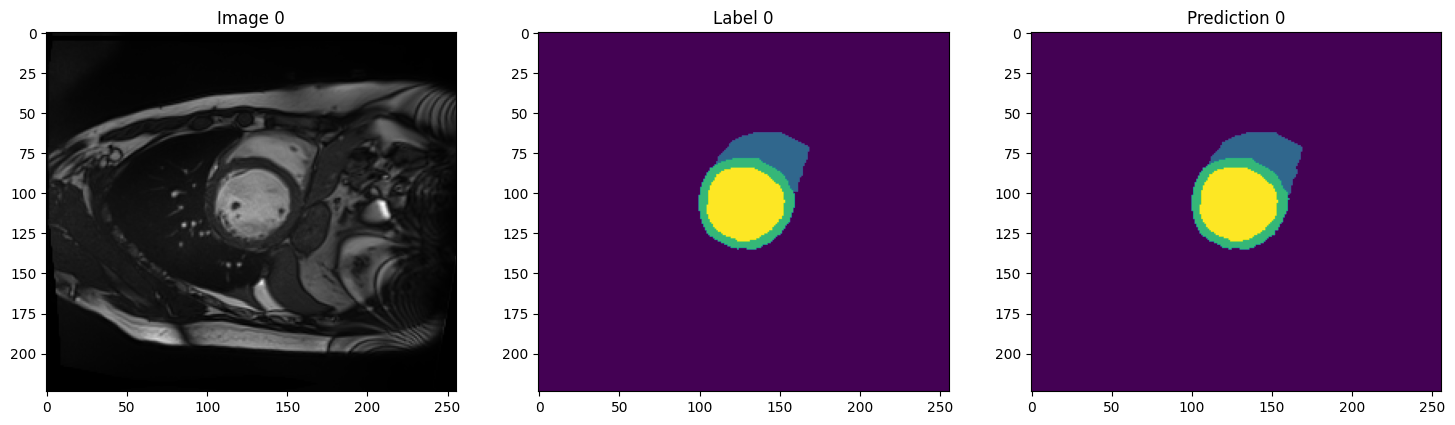

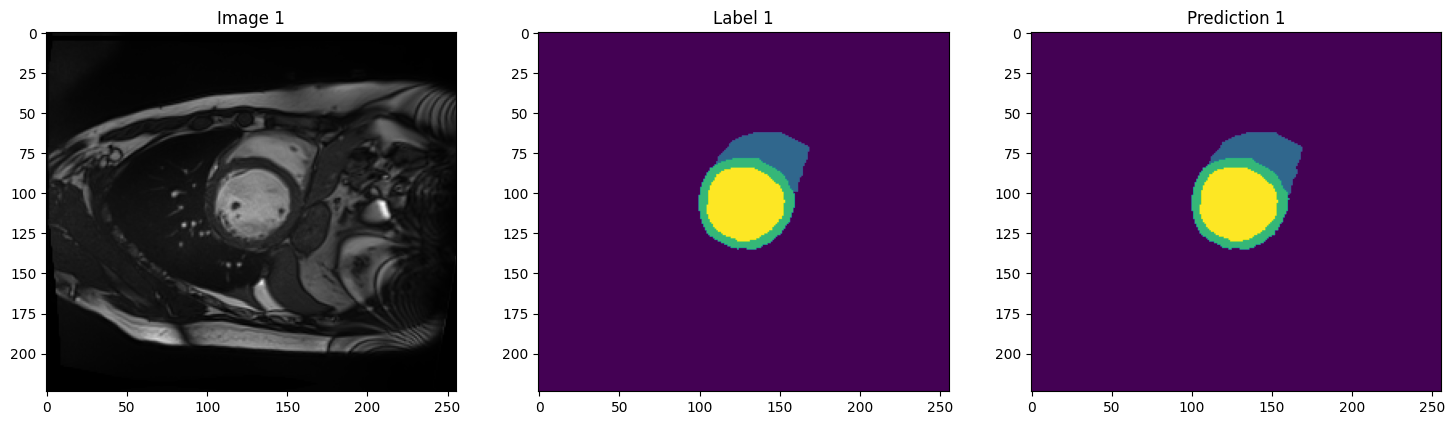

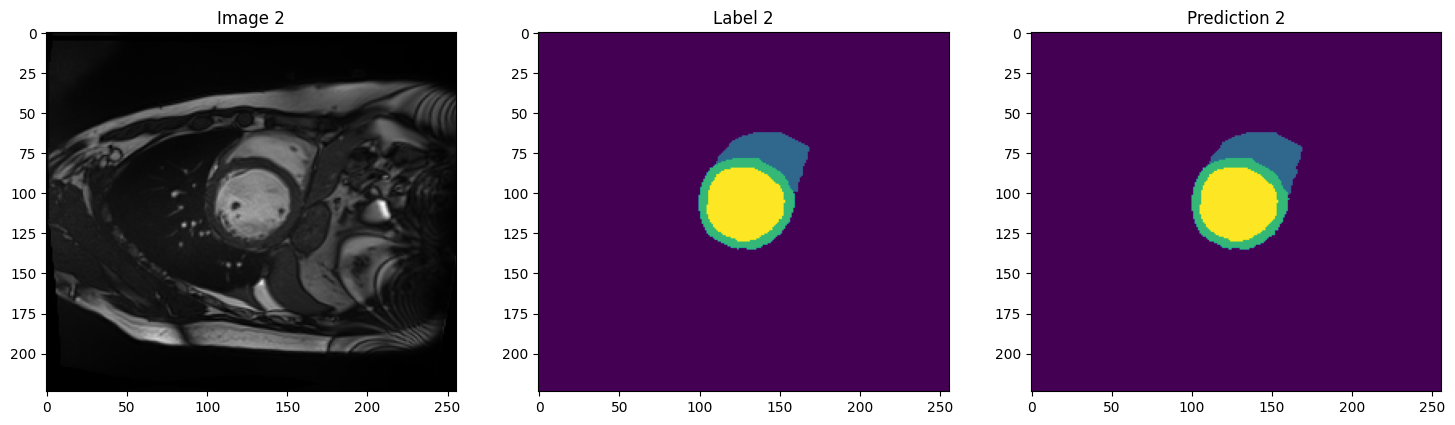

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x15eda7ec0>
Traceback (most recent call last):
  File "/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/joshstein/.pyenv/versions/3.11.1/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joshstein/.pyenv/versions/3.11.1/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joshstein/.pyenv/versions/3.11.1/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = selector.

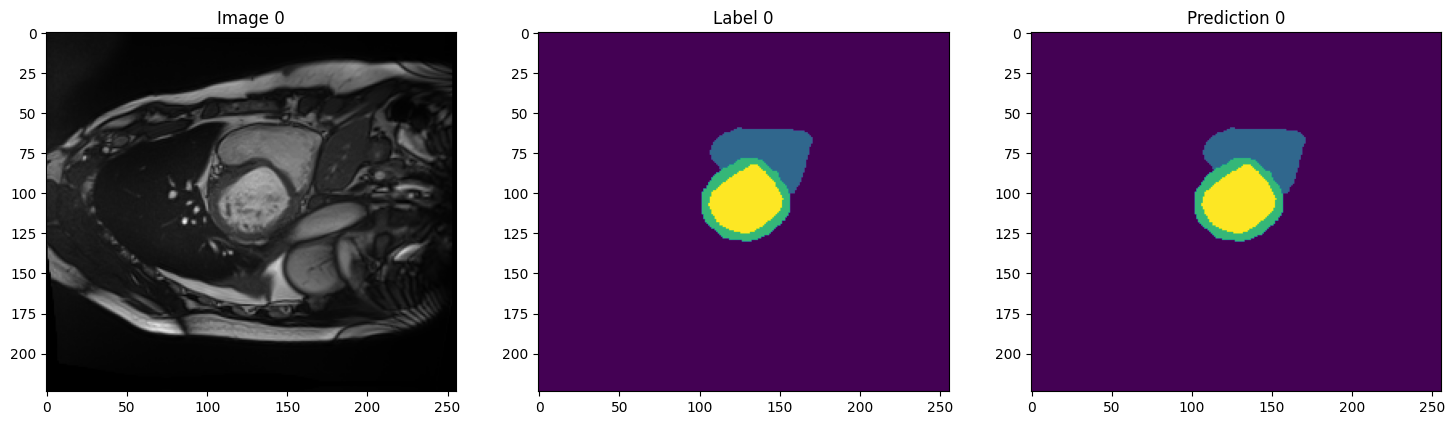

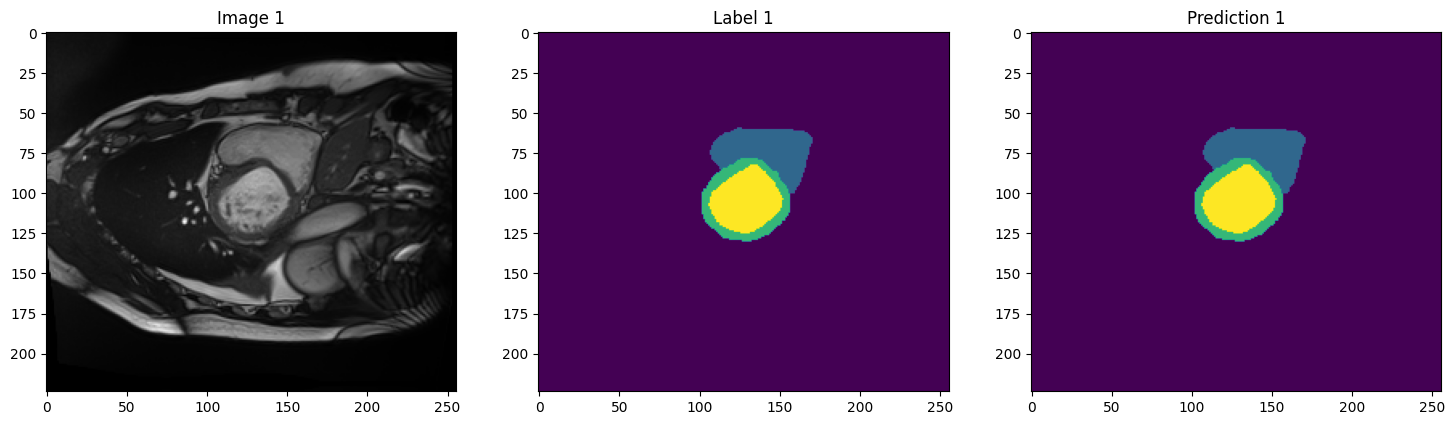

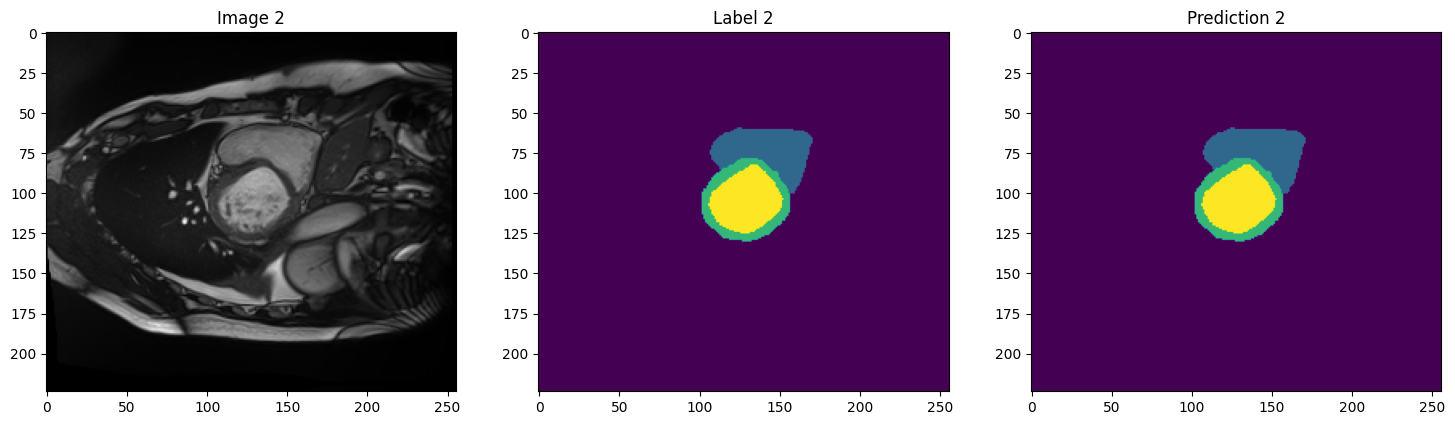

/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/Users/joshstein/Documents/thesis/code/.venv/lib/python3.11/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:


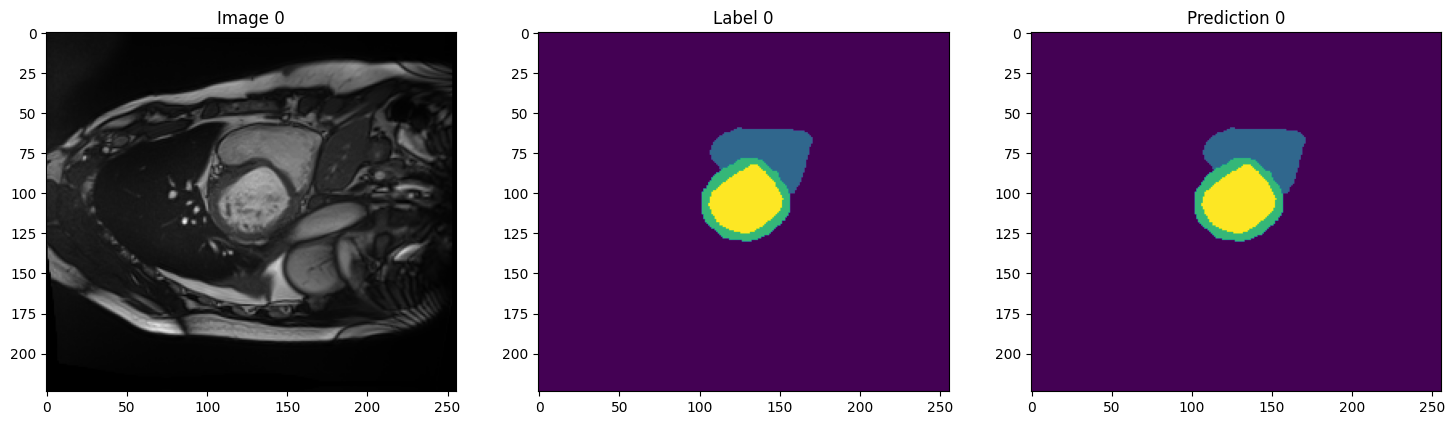

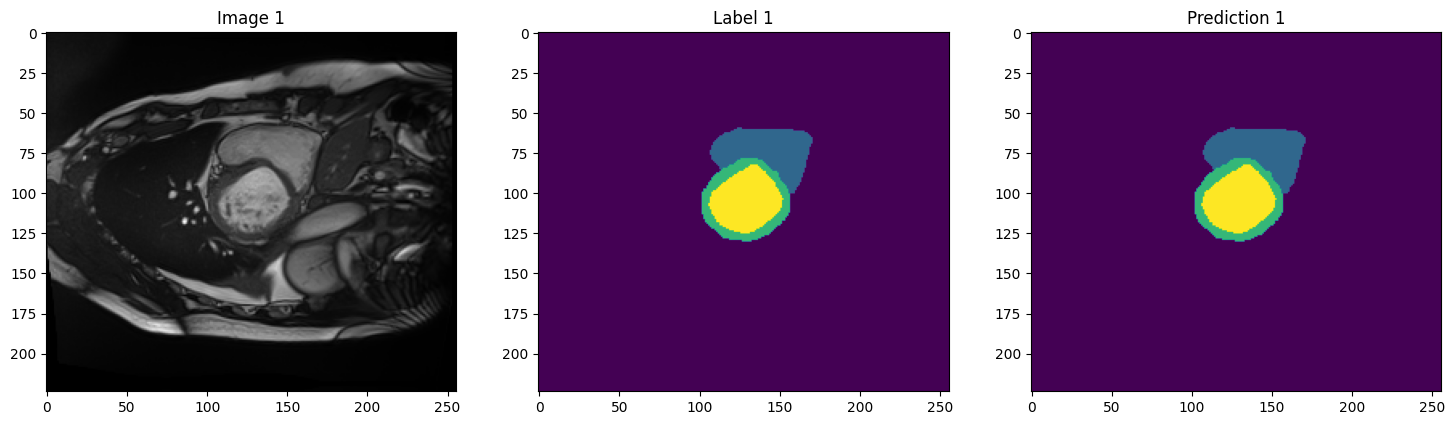

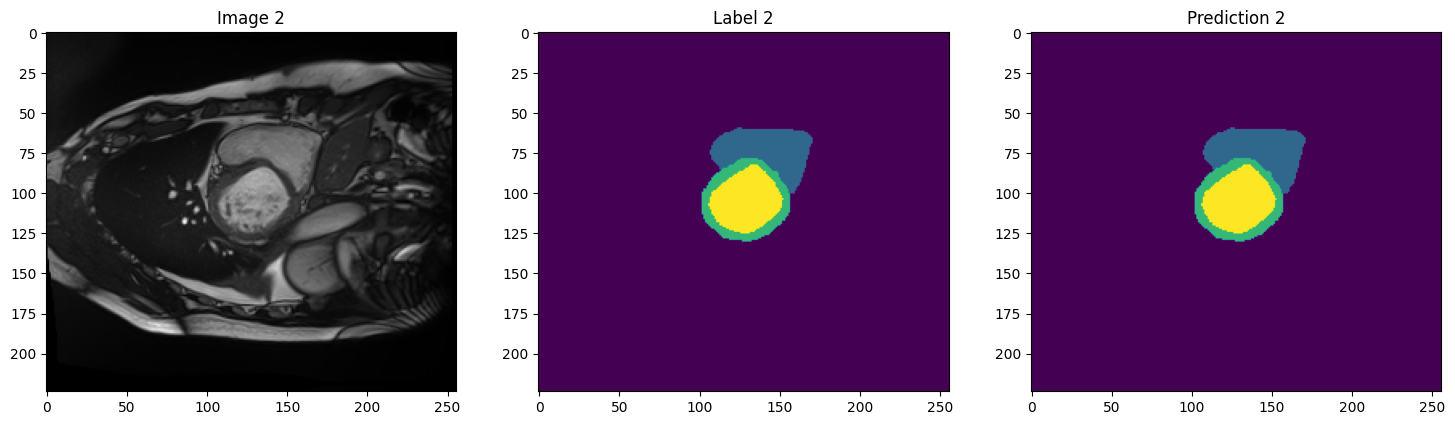

In [29]:
importlib.reload(sys.modules["src.visualization"])
from src.visualization import visualize_predictions

# visualize_loss_curves(epoch_loss_values, metric_values, val_interval, out_dir)
for slice_no in [0, 2, 4]:
    visualize_predictions(
        model=model,
        model_file=os.path.join(out_dir, "best_metric_model.pth"),
        val_loader=val_loader,
        device=device,
        slice_no=slice_no,
    )